In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.path as mpath

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
tlxfwd1 = pd.read_pickle('tlxfwd.pickle')
tlxfwd2 = pd.read_pickle('tlxfwd2.pickle')
tlxfwd3 = pd.read_pickle('tlxfwd3.pickle')
tlxfwd = pd.concat([tlxfwd1, tlxfwd2, tlxfwd3])

In [3]:
tlxfwd.reset_index(drop=True, inplace=True)
tlxfwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 15 columns):
price             468 non-null int64
year              468 non-null object
make              468 non-null object
model             468 non-null object
mileage           468 non-null int64
mpg_city          468 non-null int64
mpg_hwy           468 non-null int64
drive_type        468 non-null object
engine            468 non-null object
transmission      468 non-null object
style             465 non-null object
fuel_type         468 non-null object
interior_color    468 non-null object
exterior_color    468 non-null object
location          468 non-null object
dtypes: int64(4), object(11)
memory usage: 55.0+ KB


In [4]:
# Lets get rid of the 3 rows with missing data.  It shouldn't affect our overall model.
tlxfwd.dropna(inplace=True)

In [5]:
tlxfwd.reset_index(inplace=True, drop=True)

In [6]:
# Also let's get rid of the information in the column *style* because it is repeated
# in the columns *drive_type* and *engine*.  Some cars have a special type of package in the car
# listed in the column *style*.  We will extract that 'package' into a new column and get rid
# of the column 'style'.  If no package is stated, we'll call the package standard.

In [7]:
tlxfwd['style'].value_counts()

FWD                                 150
FWD with Technology Package         128
2.4L FWD with Technology Package     57
2.4L FWD                             53
I4 FWD                               39
I4 FWD with Technology Package       37
2.4L FWD with A-Spec Package          1
Name: style, dtype: int64

In [8]:
new_column = []
# loops through each row in the column 'style'
for style in tlxfwd['style']:
        
# Creates a list called new_column with each value
# being the cars package and creates a Pandas Series called package
        
    if 'Technology Package' in str(style):            
        new_column.append('Technology Package')
        
    elif 'A-Spec' and 'Package' in str(style):
        new_column.append('A-Spec Package')
        
    else:
        new_column.append('Standard Package')
            
    package = pd.Series(new_column)
        
tlxfwd['package'] = package

In [9]:
tlxfwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 16 columns):
price             465 non-null int64
year              465 non-null object
make              465 non-null object
model             465 non-null object
mileage           465 non-null int64
mpg_city          465 non-null int64
mpg_hwy           465 non-null int64
drive_type        465 non-null object
engine            465 non-null object
transmission      465 non-null object
style             465 non-null object
fuel_type         465 non-null object
interior_color    465 non-null object
exterior_color    465 non-null object
location          465 non-null object
package           465 non-null object
dtypes: int64(4), object(12)
memory usage: 58.2+ KB


In [10]:
new_column2 = []
# loops through each row in the column 'style'
for year in tlxfwd['year']:
        
# Creates a list called new_column2 with each value
# being the a number 0-3 associated with the year, {2016: 0, 2017: 1, 2018: 2, 2019: 3}.
       
    if '2016' in str(year):            
        new_column2.append(0)
    elif '2017' in str(year):
        new_column2.append(1)
    elif '2018' in str(year):
        new_column2.append(2)
    elif '2019' in str(year):
        new_column2.append(3)
            
    color = pd.Series(new_column2)
        
tlxfwd['color_num'] = color

In [11]:
del tlxfwd['style']

In [12]:
# Let's make our dataframe smaller by filtering to the only features we care about
tlx = tlxfwd.loc[:,['price', 'year', 'mileage', 'drive_type', 'engine', 'package', 'color_num']]

In [13]:
# convert column 'year' into int64
tlx['year'] = pd.to_numeric(tlx['year'])

In [14]:
tlx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 7 columns):
price         465 non-null int64
year          465 non-null int64
mileage       465 non-null int64
drive_type    465 non-null object
engine        465 non-null object
package       465 non-null object
color_num     465 non-null int64
dtypes: int64(4), object(3)
memory usage: 25.6+ KB


In [15]:
# seperate cars by package 
tech = tlx.loc[(tlx['package'] == 'Technology Package')]
standard = tlx.loc[(tlx['package'] == 'Standard Package')]

## TLX Depreciation with Standard Package

In [16]:
standard['year'].value_counts()

2016    150
2017     39
2019     32
2018     21
Name: year, dtype: int64

In [17]:
standard['color_num'].value_counts()

0    150
1     39
3     32
2     21
Name: color_num, dtype: int64

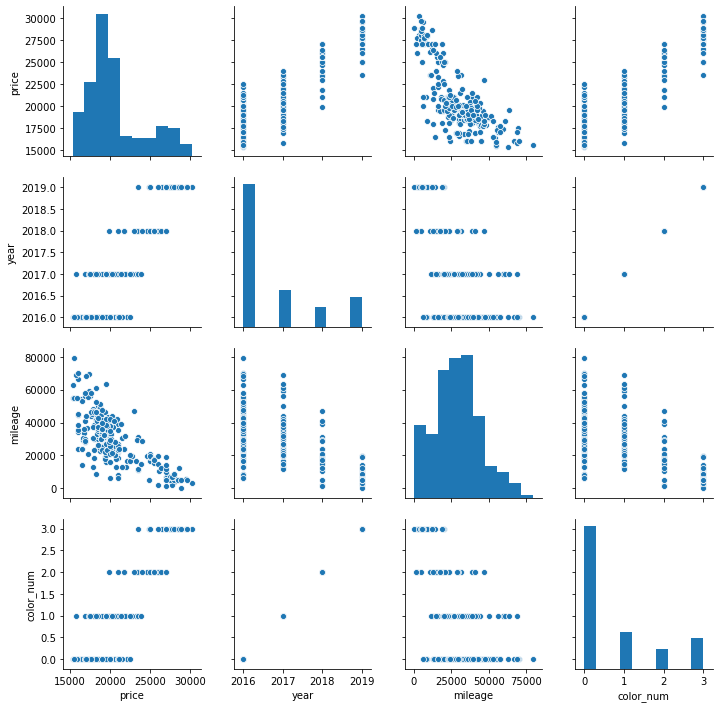

In [18]:
sns.pairplot(standard);

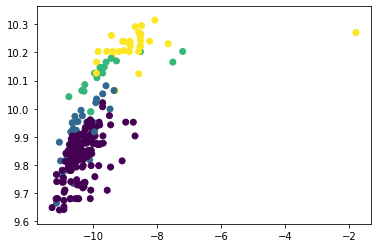

In [19]:
# mileage should be inversely related to price. i.e. cars with low mileage have higher price
# Let's graph this to see if we can capture this relation

plt.scatter(np.log(1/standard['mileage']), np.log(standard['price']), c=standard['color_num'])

In [20]:
# It seems there might be some interaction between mileage and year.  
# Let's see if this will help our model
standard['mileage_year'] = standard['mileage'] * standard['year']

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We create a linear regression model with X_standard being our features and y_standard being
what we are predicting.  Then we use train_test_split to divide our data into 3 sets.
We train our model on the train set and validate our models with the validate set.  I used A simple OLS model and an OLS model with polynomials.  

In [21]:
y_standard = standard['price']
X_standard = standard.loc[:,['mileage', 'year', 'mileage_year']]

In [22]:
X_standard_train_val, X_standard_test, y_standard_train_val, y_standard_test = train_test_split(X_standard, y_standard, test_size=0.2,random_state=41)
X_standard_train, X_standard_val, y_standard_train, y_standard_val = train_test_split(X_standard_train_val, y_standard_train_val, test_size=.25, random_state=43)

In [23]:
lr_model = LinearRegression().fit(X_standard_train, y_standard_train)
lr_model.score(X_standard_val, y_standard_val)

0.8725647817335448

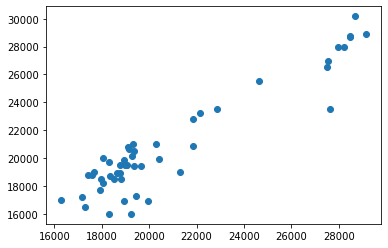

In [24]:
plt.scatter(lr_model.predict(X_standard_val), y_standard_val)

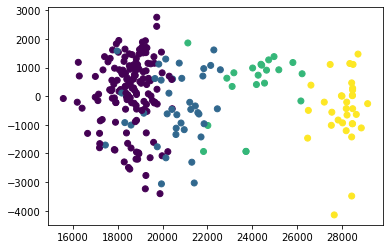

In [25]:
# Residuals look better.  Blue points moved up on graph after adding the feature.
# The interaction between year and mileage helped our model
plt.scatter(lr_model.predict(X_standard), y_standard - lr_model.predict(X_standard), c=standard['color_num'])

In [26]:
# Made a pipeline to quickly test an OLS model with polynomial features
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_standard_train, y_standard_train)
poly_model.score(X_standard_val, y_standard_val)

0.873052843096807

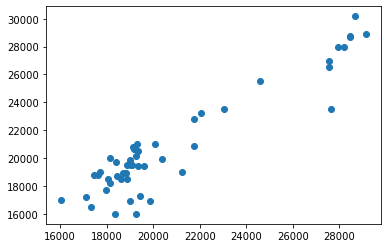

In [27]:
plt.scatter(poly_model.predict(X_standard_val), y_standard_val)

In [28]:
# We used KFold cross validation to train and validate our model on different sets of data. 
# We then took the average of all r^2 scores to further validate our model.
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lr_model, X_standard_train_val, y_standard_train_val, cv=kf, scoring='r2')
print(np.mean(cross_val_score(lr_model, X_standard_train_val, y_standard_train_val, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(poly_model, X_standard_train_val, y_standard_train_val, cv=kf, scoring='r2')))

0.8827902409988775
0.8803076345608076


In [29]:
poly_model.score(X_standard_test, y_standard_test)

0.8264175393681936

In [30]:
lr_model.score(X_standard_test, y_standard_test)

0.8283241838365064

The Lr OLS model has slightly a better r^2 score but cars typically tend to depreciate less and less as years go on and the linear model doesn't capture this.  So I'm going to choose the polynomial model to fit my data.  

In [31]:
mse = np.mean(abs(y_standard_test - poly_model.predict(X_standard_test)))
mse

1113.6646113591364

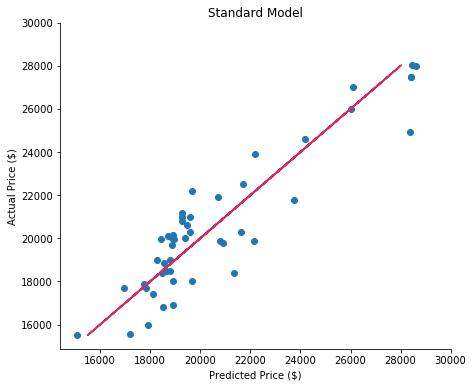

In [34]:
fig4, ax4 = plt.subplots(figsize=(7,6));

ax4.scatter(poly_model.predict(X_standard_test), y_standard_test)
ax4.plot(y_standard_test, y_standard_test, color='#dd2762')

ax4.set_xticks([16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000])
ax4.set_yticks([16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Actual Price ($)')
plt.title('Standard Model');

In [62]:
new_standard = np.array([33000, 33000, 33000, 33000, 33000])
cost_standard = new_standard - poly_model.predict(dep)
cost_standard[0] = 0
cost_standard

array([    0.        ,  5452.42132376,  9266.41254446, 12658.49163148,
       15299.57842383])

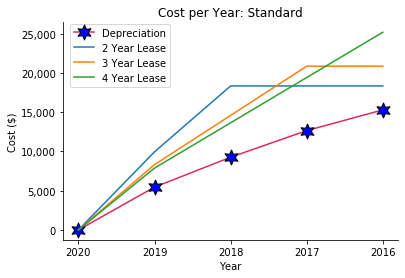

In [64]:
Years = ['2020', '2019', '2018', '2017', '2016']
star = mpath.Path.unit_regular_star(6)
ylabels3 = ['0', '5,000', '10,000', '15,000', '20,000', '25,000']

lease_2_standard = [0, 9953, 18353, 18353, 18353]
lease_3_standard = [0, 8320, 14596, 20872, 20872]
lease_4_standard = [0, 7883, 13655, 19427, 25199]

fig2, ax2 = plt.subplots(1,1)
ax2.plot(Years, cost_standard, label='Depreciation', color='#dd2762', marker=star, markersize=15, markeredgecolor='black', markerfacecolor='blue')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yticks([0, 5000, 10000, 15000, 20000, 25000])
ax2.set_yticklabels(ylabels3)
plt.xlabel('Year')
plt.ylabel('Cost ($)')
plt.title('Cost per Year: Standard');
plt.plot(Years, lease_2_standard, label='2 Year Lease')
plt.plot(Years, lease_3_standard, label='3 Year Lease')
plt.plot(Years, lease_4_standard, label='4 Year Lease')
fig2.legend(loc='upper left', bbox_to_anchor=(0.15, 0.9));

In [37]:
x = 2111 + 481 * 12
x + 481*36

25199

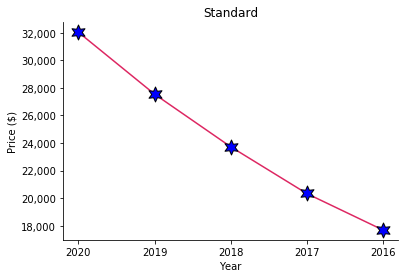

In [38]:
# Let's see our model's calculated depreciation for a car spanning 4 years with an average
# 12,000 miles per year so we can see whether a car lease allowing you to drive ~12000 miles 
# per year is worth it.  
dep = np.array([[0, 2020, 0],
                [12000, 2019, 12000*2019],
            [24000, 2018, 24000*2018],
            [36000, 2017, 36000*2017],
            [48000, 2016, 48000*2016]])


Years = ['2020', '2019', '2018', '2017', '2016']
ylabels = ['18,000', '20,000', '22,000', '24,000', '26,000', '28,000', '30,000', '32,000']
star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_regular_asterisk(5)

fig, ax = plt.subplots(1,1);
ax.plot(poly_model.predict(dep), label='polynomial', color='#dd2762', marker=star, markersize=15, markeredgecolor='black', markerfacecolor='blue')
ax.set_xticks([0,1.0,2.0,3.0, 4.0])
ax.set_xticklabels(Years)
ax.set_yticks([18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000])
ax.set_yticklabels(ylabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Standard');



## TLX Depreciation with Technology Package
We repeated the same process as above to obtain our model

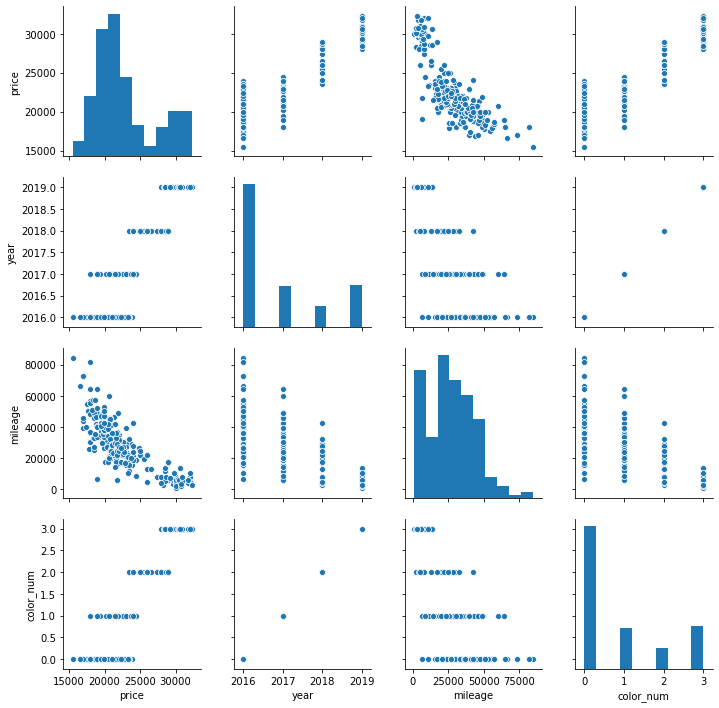

In [39]:
sns.pairplot(tech);

In [40]:
tech['mileage_year'] = tech['mileage'] * tech['year']

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


No handles with labels found to put in legend.


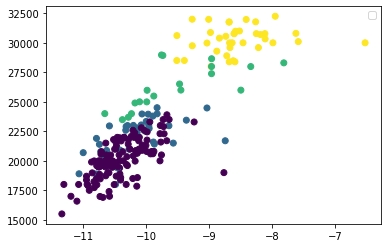

In [41]:
plt.scatter(np.log(1/tech['mileage']), tech['price'], c=tech['color_num'])
plt.legend()

In [42]:
y_tech = tech['price']
X_tech = tech.loc[:,['mileage', 'year', 'mileage_year']]

In [43]:
X_tech_train_val, X_tech_test, y_tech_train_val, y_tech_test = train_test_split(X_tech, y_tech, test_size=0.2,random_state=41)
X_tech_train, X_tech_val, y_tech_train, y_tech_val = train_test_split(X_tech_train_val, y_tech_train_val, test_size=.25, random_state=43)

In [44]:
lr_model2 = LinearRegression().fit(X_tech_train, y_tech_train)
lr_model2.score(X_tech_val, y_tech_val)

0.900576178016561

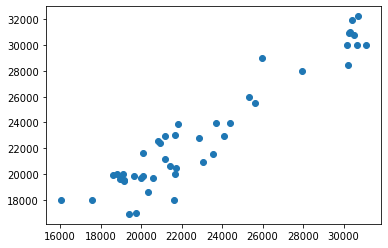

In [45]:
plt.scatter(lr_model2.predict(X_tech_val), y_tech_val)

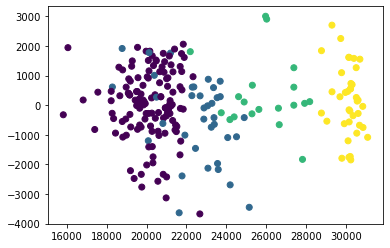

In [46]:
plt.scatter(lr_model2.predict(X_tech), y_tech - lr_model2.predict(X_tech), c=tech['color_num'])

In [47]:
plt.scatter(poly_model2.predict(X_tech_val), y_tech_val)

NameError: name 'poly_model2' is not defined

In [48]:
degree = 2
poly_model2 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model2.fit(X_tech_train, y_tech_train)
poly_model2.score(X_tech_val, y_tech_val)

0.8962095230336089

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lr_model2, X_tech_train_val, y_tech_train_val, cv=kf, scoring='r2')
print(np.mean(cross_val_score(lr_model2, X_tech_train_val, y_tech_train_val, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(poly_model2, X_tech_train_val, y_tech_train_val, cv=kf, scoring='r2')))

0.9096869186237424
0.9061874083724211


In [50]:
poly_model2.score(X_tech_test, y_tech_test)

0.894176422053721

In [51]:
mse = np.mean(abs(y_tech_test - poly_model2.predict(X_tech_test)))
mse

939.98083396822

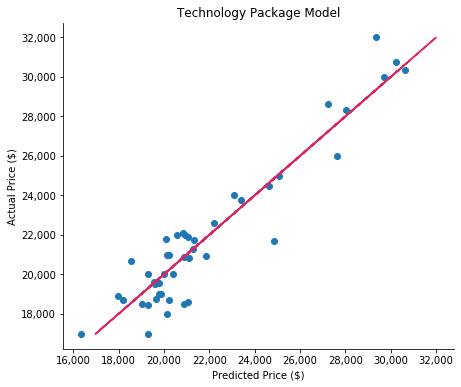

In [65]:
ylabels = ['18,000', '20,000', '22,000', '24,000', '26,000', '28,000', '30,000', '32,000']
xlabels = ['16,000', '18,000', '20,000', '22,000', '24,000', '26,000', '28,000', '30,000', '32,000']
fig, ax = plt.subplots(figsize=(7,6));

ax.scatter(poly_model2.predict(X_tech_test), y_tech_test)
ax.plot(y_tech_test, y_tech_test, color='#dd2762')

ax.set_xticks([16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000])
ax.set_yticks([18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000])
ax.set_yticklabels(ylabels)
ax.set_xticklabels(xlabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Actual Price ($)')
plt.title('Technology Package Model');

In [58]:
new_tech = np.array([36700, 36700, 36700, 36700, 36700])
cost_tech = new_tech - poly_model2.predict(dep)
cost_tech[0] = 0
cost_tech

array([    0.        ,  7550.04881458, 11582.3053434 , 15144.43804933,
       17602.60706879])

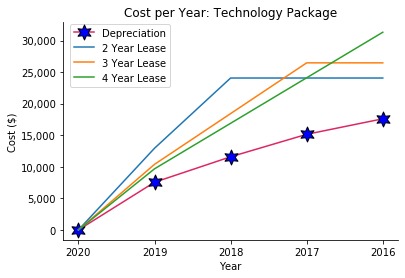

In [61]:
Years = ['2020', '2019', '2018', '2017', '2016']
ylabels2 = ['0', '5,000', '10,000', '15,000', '20,000', '25,000', '30,000']
star = mpath.Path.unit_regular_star(6)
lease_2_cost = [0, 12937, 24061, 24061, 24061]
lease_3_cost = [0, 10385, 18425, 26465, 26465]
lease_4_cost = [0, 9676, 16888, 24100, 31312]
fig1, ax1 = plt.subplots(1,1)
ax1.plot(Years, cost_tech, label='Depreciation', color='#dd2762', marker=star, markersize=15, markeredgecolor='black', markerfacecolor='blue')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
ax1.set_yticklabels(ylabels2)
plt.xlabel('Year')
plt.ylabel('Cost ($)')
plt.title('Cost per Year: Technology Package');
plt.plot(Years, lease_2_cost, label='2 Year Lease')
plt.plot(Years, lease_3_cost, label= '3 Year Lease')
plt.plot(Years, lease_4_cost, label= '4 Year Lease')
fig1.legend(loc='upper left', bbox_to_anchor=(0.15, 0.9));

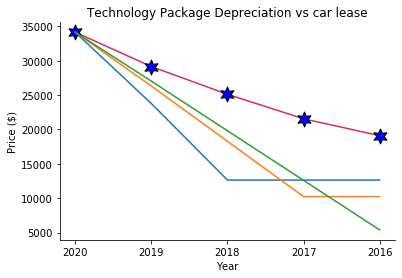

In [287]:
dep = np.array([[0, 2020, 0],
                [12000, 2019, 12000*2019],
            [24000, 2018, 24000*2018],
            [36000, 2017, 36000*2017],
            [48000, 2016, 48000*2016]])

lease_2x_vals = [0, 1.0, 2.0, 3.0, 4.0]
lease_2y_vals = [34144, 23763, 12639, 12639, 12639]

lease_3x_vals = [0, 1.0, 2.0, 3.0, 4.0]
lease_3y_vals = [34144, 26315, 18275, 10235, 10235]

lease_4x_vals = [0, 1.0, 2.0, 3.0, 4.0]
lease_4y_vals = [34144, 27024, 19812, 12600, 5388]

Years = ['2020', '2019', '2018', '2017', '2016']
ylabels = ['18,000', '20,000', '22,000', '24,000', '26,000', '28,000', '30,000', '32,000']
star = mpath.Path.unit_regular_star(6)

fig, ax = plt.subplots(1,1);
ax.plot(poly_model2.predict(dep), label='polynomial', color='#dd2762', marker=star, markersize=15, markeredgecolor='black', markerfacecolor='blue')
ax.set_xticks([0,1.0,2.0,3.0, 4.0])
ax.set_xticklabels(Years)
# ax.set_yticks([18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000])
# ax.set_yticklabels(ylabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Technology Package Depreciation vs car lease');
plt.plot(lease_2x_vals, lease_2y_vals)
plt.plot(lease_3x_vals, lease_3y_vals)
plt.plot(lease_4x_vals, lease_4y_vals)